#ALM: Image Pathology

The purpose of this notebook is to develop the idea that functional safety faults in IPU FF can be detected using image statistics. 

The idea: a SW monitor running on the DSP will compute statistical metrics on frames report FuSa failures related to image quality. 

###Pros:


*   Can detect transient failures, running on many frames or all frames
*   The rate of tested frames can be tuned to achive the desired FIT level. At maximum, *Image Pathology* can run on every frame.
*  Tests the actual image that ran through the pipe, rather than a test pattern that may have run with a seperate VC, potentially on a different topology and maybe with different OF configurations

###Cons:
* The decision threshold ("Final Voting") is based on statistical characterization of images, thus will create false positives (fault indication where there is no real fault). Hopefully, false positives rate can be tuned to be negligible. Assumption: It is better to have a few false alarms if the fault coverage is increased substantially.
* *Image Pathology* consumes DSP capacity and power. The tradeoff between fault coverage and power can be tuned, though.

*Image Pathology* does not replace "ALM: Test Pattern" (TPG). It complements it in order to achieve better FuSa coverage on IPU. FMEDA will determine the scope of *Image Pathology* tests that would be needed to meet the required FuSa metrics. 

Some of the errors can be easily detected by a human user. Some - cannot.
While for human consumption, we can maybe avoid issuing a FuSa fault indication, we NEED to detect failures in images which are inputs for CV algorithms. 

A CNN-based Neural network like MAGIC is relevant for FuSa in 2 ways:
* We need to detect FuSa failures in it, if we define a safety goal on its outputs
* We may be able to train and use it for detection of SOTIF failures, such as: Mud on the sensor/window, fog, rain, sand storm and other. 

This Jupyter notebook is a starting point, showing common image quality faults and how they may be potentially detected. It is simplistic, and serves to solicit feedback on the general direction of this feature. If this feature has merit, working with Algo experts is needed to design better fault detection metrics.


Thanks,
Tal Davidson





In [15]:
!pip install scikit-image  --upgrade

     |████████████████████████████████| 12.4MB 5.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import skimage
from skimage import img_as_float
from skimage.io import imsave
from skimage.filters import window
from skimage.color import rgb2gray
from skimage.filters import difference_of_gaussians
from scipy.fftpack import fft2, fftshift
print(skimage.__version__)

0.17.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/mandi.tif"
bayer = plt.imread(path)


We will use "Mandi.Tiff" which is a bayer (RGGB) image:

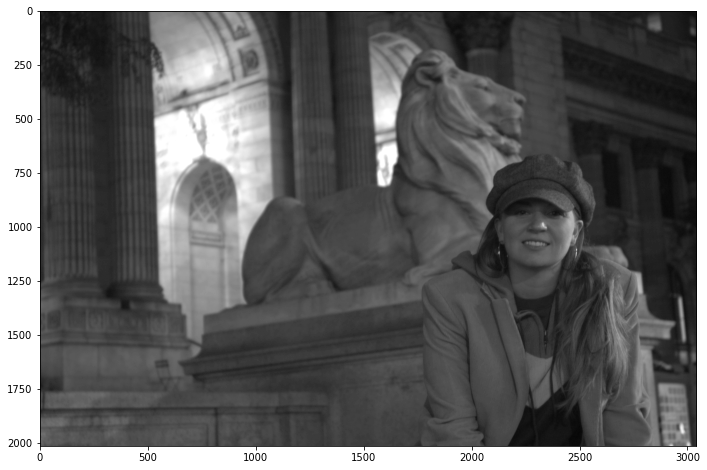

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.imshow(bayer, cmap='gray')

Here's its histogram:

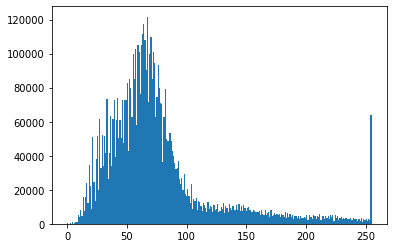

In [9]:
plt.hist(bayer.ravel(), bins=256);

Defining some helper functions:

In [10]:
def demosaic_simple(bayer_image) :
    
    h= bayer_image.shape[0]
    w = bayer_image.shape[1]
    oh = h//2
    ow =w//2
    B = bayer_image[0::2,0::2]
    R = bayer_image[1::2,1::2]
    G0 = bayer_image[1::2,0::2]
    G1  = bayer_image[0::2,1::2]
    R = R[:oh,:ow]
    B = B[:oh,:ow]
    G = G0[:oh,:ow]//2 + G1[:oh,:ow]//2
    return np.dstack((R,G,B))


In [31]:
out = demosaic_simple(bayer)   #Demosaicing the original bayer image of Mandi

#Linearization failures
Failure to linearize a bayer image will result in either dark shadows or washed-out higlights, which may conceal hazard to the road user in highlights/shadows. 

Opens:
Will AE be able to compensate for non-linearity? What is the Exposure is already set to max?

We will multiply the bayer image intensities by the non-linear functions presented below:

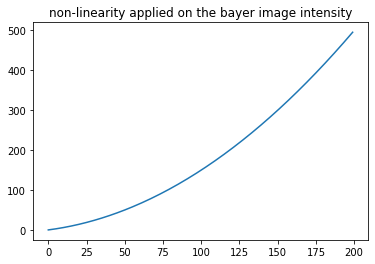

In [32]:
# Applying non-linearity on the image, to mimic a non-linear bayer sensor
x=np.arange(200)
y= 0.5*x+0.01*x**2
plt.plot(x,y)
plt.title('non-linearity applied on the bayer image intensity');

In [33]:
bayer_non_linear = 0.5*bayer+0.01*bayer**2  # non-linearized bayer
out_non_linear=demosaic_simple(bayer_non_linear)

(0.0, 120000.0)

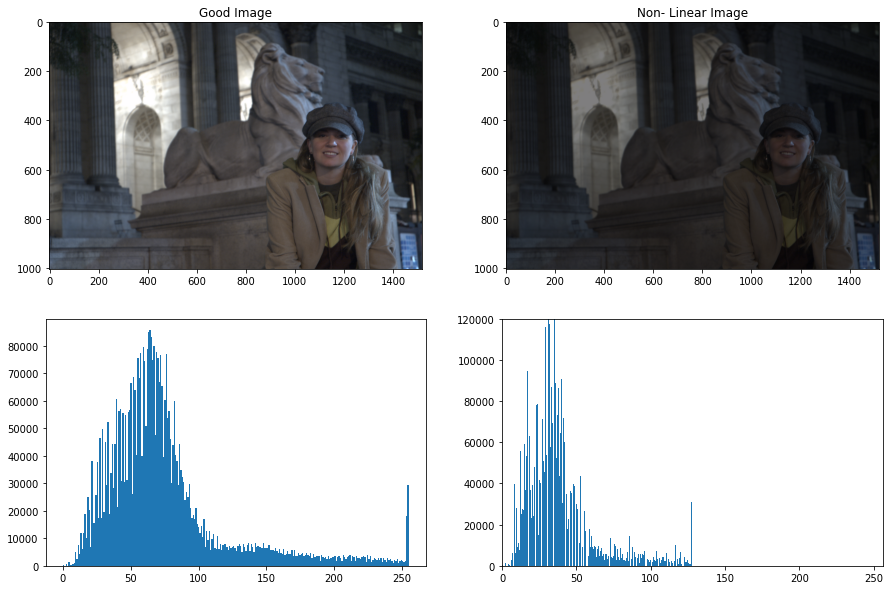

In [34]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0,0].imshow(out)
ax[0,0].set_title('Good Image')
ax[0,1].imshow(out_non_linear.astype(int))
ax[0,1].set_title('Non- Linear Image')
ax[1,0].hist(out.ravel(), bins=256);
ax[1,1].hist(out_non_linear.ravel(), bins=256);
ax[1,1].set_xlim([0,256])
ax[1,1].set_ylim([0,120000])

The image histogram is condensed, and shadow detail disapear.

###Potential detection mechanism for non-linearity
Calculating the variance of the histogram bins.
For a non-linear image, the variance is much higher than a linear image.

variance of histogram of the original image: 274953629533.29004


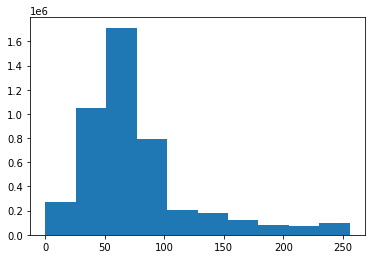

In [48]:
hist_values = plt.hist(out.ravel(), bins=10, range=(0,256))
print("variance of histogram of the original image:", hist_values[0].var())

variance of histogram of the non-linear image: 622754995812.69


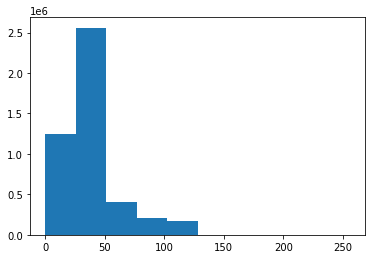

In [49]:
hist_values_nl = plt.hist(out_non_linear.ravel(), bins=10, range=(0,256))
print("variance of histogram of the non-linear image:", hist_values_nl[0].var())

#Lens Shading Correction Failures

Lens shading error may result in dark areas in the edges of the image, concealing road hazards.

In [52]:
wimage = bayer * window('hann', bayer.shape)
wimage_out = demosaic_simple(wimage)
image_f = np.abs(fftshift(fft2(rgb2gray(out))))
wimage_f = np.abs(fftshift(fft2(rgb2gray(wimage_out))))

(0.0, 120000.0)

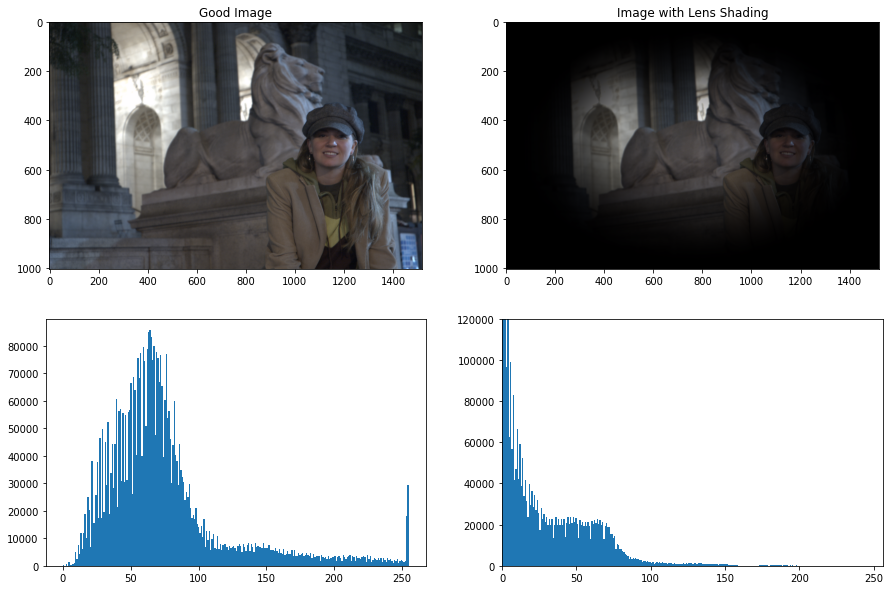

In [54]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0,0].imshow(out)
ax[0,0].set_title('Good Image')
ax[0,1].imshow(wimage_out.astype(int))
ax[0,1].set_title('Image with Lens Shading')
ax[1,0].hist(out.ravel(), bins=256);
ax[1,1].hist(wimage_out.ravel(), bins=256);
ax[1,1].set_xlim([0,256])
ax[1,1].set_ylim([0,120000])


###Potential Detection Mechanism for lens shading
LSC-corrected image - Histograms on center and edges look similar.

LSC-noncorrected image - Histograms on sides are materially different

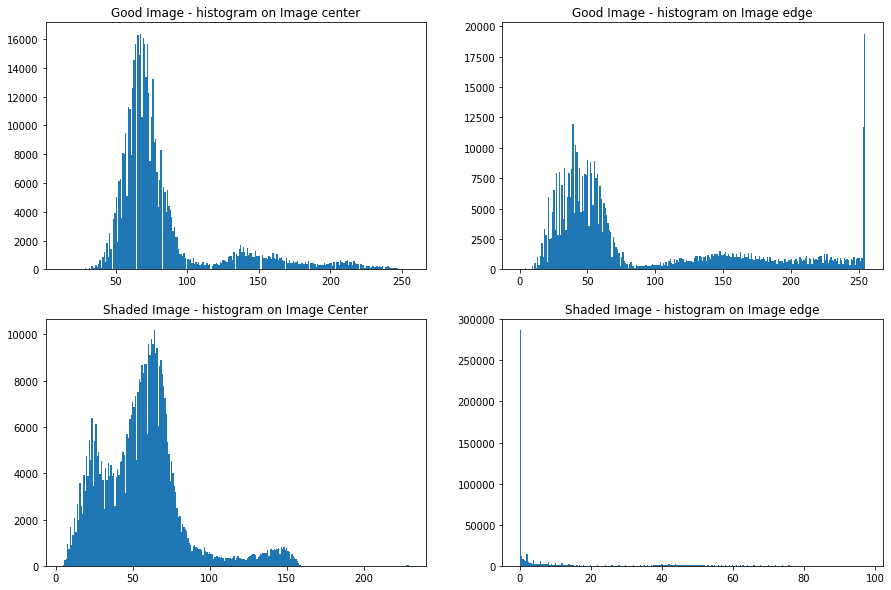

In [55]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0,0].set_title('Good Image - histogram on Image center')
ax[0,0].hist(out[400:800,400:800].ravel(), bins=256);
ax[0,1].set_title('Good Image - histogram on Image edge')
ax[0,1].hist(out[0:400,0:400].ravel(), bins=256);
ax[1,0].set_title('Shaded Image - histogram on Image Center')
ax[1,0].hist(wimage_out[400:800,400:800].ravel(), bins=256);
ax[1,1].set_title('Shaded Image - histogram on Image edge')
ax[1,1].hist(wimage_out[0:400,0:400].ravel(), bins=256);

# Detection of Blurry Images
## Due to Faults in AF statistics, BNLM, Sharpening, etc.

Blurred images makes it harder for the user (and CV algo) to detect road hazards.

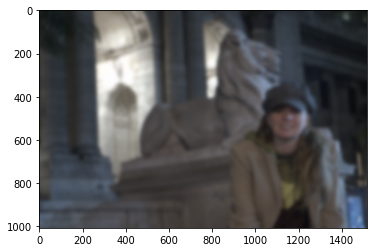

In [56]:
blurry_out = skimage.filters.gaussian(out, sigma=8,multichannel=True)
plt.imshow(blurry_out.astype('float'))

###Potential Dection Mechanism for blurry images

The idea: calculate the variance of the laplacian of the image. The variance will be lower the more blurry the image is.

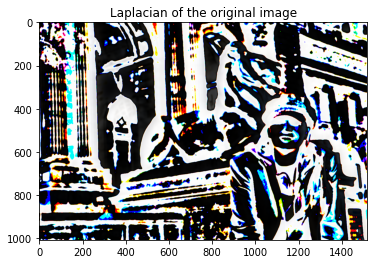

In [59]:
filtered_out = difference_of_gaussians(out,2,30, multichannel=True)
plt.imshow((filtered_out*128).astype(np.uint8));
plt.title('Laplacian of the original image');

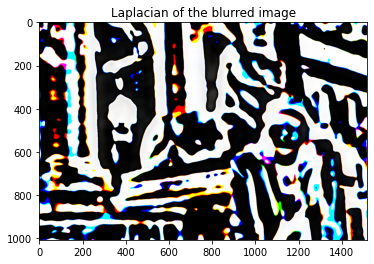

In [60]:
filtered_blurry_out = difference_of_gaussians(blurry_out,2,30, multichannel=True)
plt.imshow((filtered_blurry_out* 128).astype(np.uint8));
plt.title('Laplacian of the blurred image');

In [61]:
print('Variance of laplacian of the original image', np.var(filtered_out)*1000)
print('Variance of laplacian of the blurred image', np.var(filtered_blurry_out)*1000)


Variance of laplacian of the original image 4.83477929868944
Variance of laplacian of the blurred image 2.6861862703419592


###Demosaicing Errors

Demosaicing errors results in bad colors, which are obviously seen by the user. Therefore, I am not sure how important it is to detect those errors for the the safety goal of human image consumption. 
However, CV algo performance may degrade if such errors exist. 

I am not aware of an easy way to detect demosaic error computationally. Maybe this paper is a promising lead: 
https://www.researchgate.net/publication/224602178_Accurate_Detection_of_Demosaicing_Regularity_for_Digital_Image_Forensics

Below - see a demosaic error - shifting between Green, Blue and Red

In [62]:
def bad_demosiac(bayer_image): # R and B are flipped

  h= bayer_image.shape[0]
  w = bayer_image.shape[1]
  oh = h//2
  ow =w//2
  G0 = bayer_image[0::2,0::2]
  B = bayer_image[1::2,1::2]
  R = bayer_image[1::2,0::2]
  G1  = bayer_image[0::2,1::2]
  R = R[:oh,:ow]
  B = B[:oh,:ow]
  G = G0[:oh,:ow]//2 + G1[:oh,:ow]//2
  return np.dstack((R,G,B))

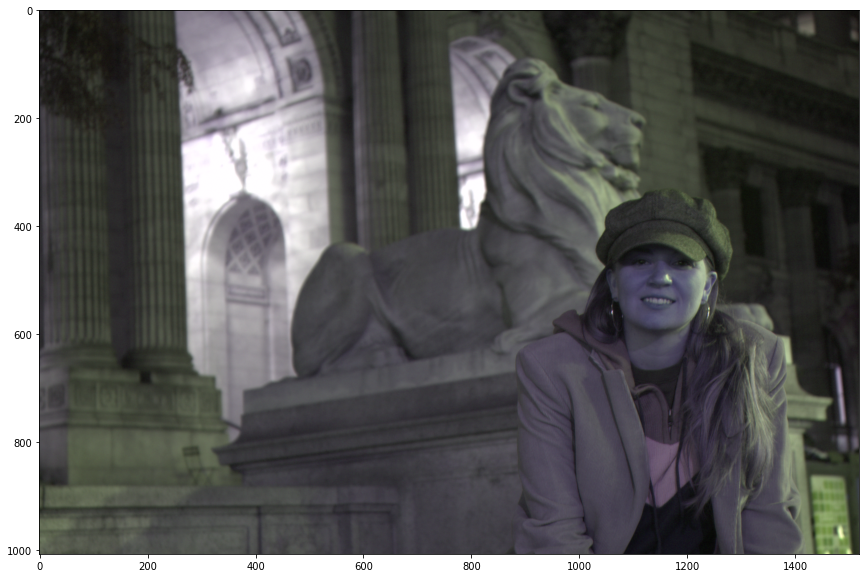

In [63]:
out_bad_demosaic = img_as_float(bad_demosiac(bayer))
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(out_bad_demosaic)

###Failures in Noise Reduction algorithms

Potentially detect using PSNR calculation

###Failures resulting in a defect row, column, tile, area

Potentially detect using Spatial similarity between consecutive frames (SSIM), when we know that the vehicle is moving (maybe through using an IMU)

### SOTIF Failures (Mud on the sensor, Rain, Fog, etc..)
potentially train MAGIC-V/X to detect such errors